In [1]:
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

In [2]:
data = pd.read_csv("vehicles.csv")

In [3]:
def graphical_numerical_summaries(data, variable):
    plt.figure(figsize=(8, 4))
    plt.subplot(1,2,1)
    sns.histplot(data[variable], bins=50, kde=True)
    plt.title(f'Histogram of {variable} Distribution')
    plt.xlabel('Price')
    plt.ylabel('Frequency')
    
    plt.subplot(1,2,2)
    sns.boxplot(x=data[variable])
    plt.title(f'Box Plot of {variable} Distribution')
    plt.tight_layout()
    plt.show()

    return data[variable].describe(percentiles = [0.25,0.50,0.75,0.85,0.90,1])


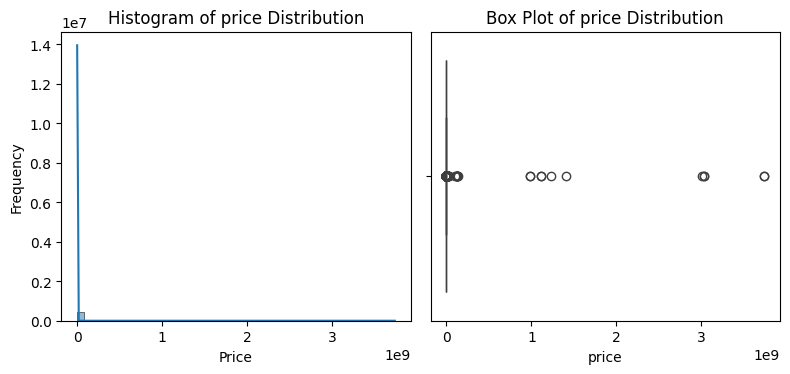

count    4.268800e+05
mean     7.519903e+04
std      1.218228e+07
min      0.000000e+00
25%      5.900000e+03
50%      1.395000e+04
75%      2.648575e+04
85%      3.299500e+04
90%      3.759000e+04
100%     3.736929e+09
max      3.736929e+09
Name: price, dtype: float64

In [4]:
graphical_numerical_summaries(data, 'price')

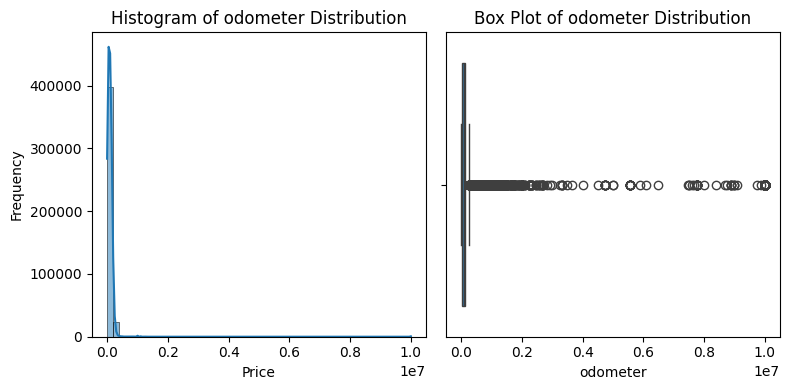

count    4.224800e+05
mean     9.804333e+04
std      2.138815e+05
min      0.000000e+00
25%      3.770400e+04
50%      8.554800e+04
75%      1.335425e+05
85%      1.596287e+05
90%      1.773771e+05
100%     1.000000e+07
max      1.000000e+07
Name: odometer, dtype: float64

In [5]:
graphical_numerical_summaries(data, 'odometer')

In [6]:
# Add vehicle age column
data['posting_date'] = pd.to_datetime(data['posting_date'], utc=True)
data['posting_year'] = data['posting_date'].dt.year
data['vehicle_age'] = data['posting_year'] - data['year']
#data = data.drop(['year', 'posting_year'], axis='columns')

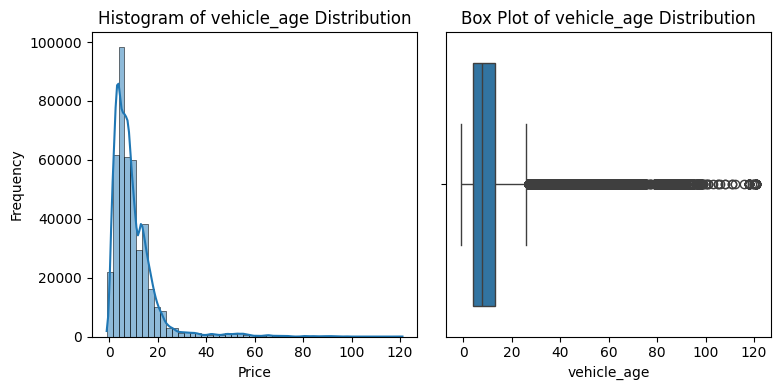

count    425675.000000
mean          9.764809
std           9.452120
min          -1.000000
25%           4.000000
50%           8.000000
75%          13.000000
85%          16.000000
90%          18.000000
100%        121.000000
max         121.000000
Name: vehicle_age, dtype: float64

In [7]:
graphical_numerical_summaries(data, 'vehicle_age')

In [8]:
# Function to remove outliers based on the IQR method within each state
def remove_outliers(df):
    df_out = pd.DataFrame()
    for key, subdf in df.groupby('state'):
        Q1 = subdf['price'].quantile(0.25)
        Q3 = subdf['price'].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        reduced_df = subdf[(subdf.price >= lower) & (subdf.price <= upper)]
        df_out = pd.concat([df_out, reduced_df], ignore_index=True)
    return df_out

In [9]:
def data_cleaning(data):
    
    # Drop irrelevant features
    data = data.drop(['id', 'url', 'region_url', 'image_url', 'description', 'lat', 
                      'long', 'region', 'VIN', 'title_status', 'type', 'cylinders', 'county', 
                      'model', 'size', 'year', 'posting_year', 'posting_date'], axis='columns')

    # Drop rows with missing values
    data = data.dropna()
    
    # Remove 'harley-davidson' since it's not a car brand
    data = data[~(data.manufacturer == 'harley-davidson')]

    # Group manufacturers with low counts as 'other'
    manufacturer_count = data['manufacturer'].value_counts()
    manufacturer_less_than_100 = manufacturer_count[manufacturer_count < 100].index
    data['manufacturer'] = data['manufacturer'].apply(lambda x: 'other' if x in manufacturer_less_than_100 else x)
    
    # Remove rows with price equal to 0
    data = data[data.price != 0]

    # Apply outlier removal function
    data = remove_outliers(data)

    # Remove samples with unrealistic odometer readings
    data = data[(data.odometer > 1000) & (data.odometer <= 500000)]
    
    # Split data into vintage and non-vintage cars
    df_nonvintage = data[(data.vehicle_age > 0) & (data.vehicle_age < 30)]
    df_vintage = data[(data.vehicle_age >= 30) & (data.vehicle_age <= 100)]
    
    # Remove duplicates in the non-vintage data
    df_nonvintage = df_nonvintage.drop_duplicates()
    df_vintage = df_vintage.drop_duplicates()

    #1 hot encoding
    df_nonvintage_encoded= pd.get_dummies(df_nonvintage, columns=['manufacturer', 'condition', 'fuel','transmission', 'drive',
                                      'paint_color', 'state'],  dtype=int, prefix='', prefix_sep='')
    df_vintage_encoded= pd.get_dummies(df_vintage, columns=['manufacturer', 'condition', 'fuel','transmission', 'drive',
                                      'paint_color', 'state'],  dtype=int, prefix='', prefix_sep='')


    #remove 1 level from each categorical feature to avoid multicollinearity
    #state= nd (least count), pain_color=custom, fuel= other, transmission= other, drive= rwd  (least count), 
    #condition= salvage (least count), manufacturer= other 
    df_nonvintage_encoded.drop(['nd','other','custom','other','other','rwd','salvage'], axis='columns', inplace=True)
    df_vintage_encoded.drop(['nd','other','custom','other','other','rwd','salvage'], axis='columns', inplace=True)
    
        
    #split into x(input) and y (target/output)
    
    x_nonvintage = df_nonvintage_encoded.drop('price', axis='columns')
    y_nonvintage = df_nonvintage_encoded.price
    x_vintage = df_vintage_encoded.drop('price', axis='columns')
    y_vintage = df_vintage_encoded.price


    #since nonvintage cars dataset contains 102,433 samples an 80/20 split will suffice
    x_nonvintage_train, x_nonvintage_test,y_nonvintage_train, y_nonvintage_test = train_test_split(x_nonvintage, y_nonvintage, test_size= 0.2, random_state=123) 
    x_vintage_train, x_vintage_test,y_vintage_train, y_vintage_test = train_test_split(x_vintage, y_vintage, test_size= 0.2, random_state=123) 
    


    return  x_nonvintage_train, x_nonvintage_test,y_nonvintage_train, y_nonvintage_test, x_vintage_train, x_vintage_test,y_vintage_train, y_vintage_test

In [10]:
x_nonvintage_train, x_nonvintage_test,y_nonvintage_train, y_nonvintage_test, x_vintage_train, x_vintage_test,y_vintage_train, y_vintage_test = data_cleaning(data)

In [11]:
#define function to test different models using GridSearchCV for parameter tuning
def find_best_model_using_gridsearchcv(X, y):
    algorithms = {
        'linear_regression': {
            'model': LinearRegression(),
            'params': {
                'fit_intercept': [True, False]
            }
        },
        'lasso': {
            'model': Lasso(),
            'params': {
                'alpha': [0.1, 1],  # Adjusted alpha values
                'selection': ['random', 'cyclic']
            }
        },
        'decision_tree': {
            'model': DecisionTreeRegressor(random_state=123),
            'params': {
                'criterion': ['squared_error', 'friedman_mse'],
                'splitter': ['best', 'random']
            }
        },
        'random_forest': {
            'model': RandomForestRegressor(random_state=123),
            'params': {
                'n_estimators': [50,100]
            }
                }
        ,

        'xgboost': {
            'model': xgb.XGBRegressor(random_state=123),
            'params':{
                'n_estimators': [100, 200], 
                'max_depth': [3, 5]
            }
        }
    }
    
    scores = []
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

    for algo_name, config in algorithms.items():
        try:
            gs = GridSearchCV(config['model'], config['params'], cv=cv,
                              return_train_score=False, n_jobs=-1)
            gs.fit(X, y)
            scores.append({
                'model': algo_name,
                'best_score_': gs.best_score_,
                'best_params_': gs.best_params_
            })
        except Exception as e:
            print(f"Error in {algo_name}: {e}")

    return pd.DataFrame(scores)

# Call the function
results = find_best_model_using_gridsearchcv(x_nonvintage_train, y_nonvintage_train)
results


/Users/marwa/Desktop/CarPrice/.carpriceenv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.247e+12, tolerance: 8.073e+08
  model = cd_fast.enet_coordinate_descent(
/Users/marwa/Desktop/CarPrice/.carpriceenv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.220e+12, tolerance: 8.093e+08
  model = cd_fast.enet_coordinate_descent(
/Users/marwa/Desktop/CarPrice/.carpriceenv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale 

,model,best_score_,best_params_
0,linear_regression,0.689522,{'fit_intercept': True}
1,lasso,0.689643,"{'alpha': 0.1, 'selection': 'random'}"
2,decision_tree,0.677040,"{'criterion': 'squared_error', 'splitter': 'be..."
3,random_forest,0.817332,{'n_estimators': 100}
4,xgboost,0.801769,"{'max_depth': 5, 'n_estimators': 200}"


In [12]:
rf= RandomForestRegressor(n_jobs=-1, random_state=123)
rf.fit(x_nonvintage_train, y_nonvintage_train)
rf.score(x_nonvintage_test, y_nonvintage_test)

0.8185059501913325

In [13]:
def predict_price( manufacturer, condition, fuel, odometer, transmission, drive, paint_color, state, vehicle_age):

    
    # Initialize an array of the size of all the columns in x_nonvintage
    x = np.zeros(len(x_nonvintage_train.columns)) 

    #set first two indices to our numeric features
    x[0] = odometer              
    x[1] = vehicle_age

    # list of categorical features
    features = [state, manufacturer, condition, fuel, transmission, paint_color, drive]
    
    # for all categores in a categorical feature, loop over the categories
    for category in features:
        
        # Check if the category is in our data x_nonvintage
        if category in x_nonvintage_train.columns:
            
            # Get the index for the one hot encoded category in that data
            idx = np.where(x_nonvintage_train.columns == category)[0][0]

            #set that category index=1 (categories for that categorical feature that are not in x_nonvintage will be 0)
            x[idx] = 1
       
    # prediction
    return rf.predict([x])[0]

In [14]:
predict_price('bmw', 'like new', 'diesel', 120000, 'automatic', '4wd', 'black', 'la', 5)

/Users/marwa/Desktop/CarPrice/.carpriceenv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


np.float64(19961.07)

In [15]:
import joblib
joblib.dump(rf, 'used_car_price_model.pkl')

['used_car_price_model.pkl']

In [16]:
model_columns = x_nonvintage_train.columns.tolist()
joblib.dump(model_columns, 'model_columns.pkl')

['model_columns.pkl']